In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_med = pd.read_csv('Medical_Data_Set/medical_clean.csv')
original_df_med = pd.read_csv('Medical_Data_Set/medical_clean.csv')
pd.set_option('display.max_columns', None)

# When True, displays extensive summary statistics and plots. Output streamlined when False.
run_verbose = False

all_columns = ['CaseOrder', 'Customer_id', 'Interaction', 'UID', 'City', 'State',
               'County', 'Zip', 'Lat', 'Lng', 'Population', 'Area', 'TimeZone', 'Job',
               'Children', 'Age', 'Income', 'Marital', 'Gender', 'ReAdmis',
               'VitD_levels', 'Doc_visits', 'Full_meals_eaten', 'vitD_supp',
               'Soft_drink', 'Initial_admin', 'HighBlood', 'Stroke',
               'Complication_risk', 'Overweight', 'Arthritis', 'Diabetes',
               'Hyperlipidemia', 'BackPain', 'Anxiety', 'Allergic_rhinitis',
               'Reflux_esophagitis', 'Asthma', 'Services', 'Initial_days',
               'TotalCharge', 'Additional_charges', 'Item1', 'Item2', 'Item3', 'Item4',
               'Item5', 'Item6', 'Item7', 'Item8']

identifier_cat_columns = ['CaseOrder', 'Customer_id', 'Interaction', 'UID']

large_cat_columns = ['City', 'County', 'Zip', 'Job']

small_cat_columns = ['State', 'Area', 'TimeZone', 'Marital', 'Gender', 'Initial_admin', 'Complication_risk', 'Services']

yes_no_columns = ['ReAdmis', 'Soft_drink', 'HighBlood', 'Stroke', 'Overweight', 'Arthritis', 'Diabetes',
                  'Hyperlipidemia', 'BackPain', 'Anxiety', 'Allergic_rhinitis', 'Reflux_esophagitis', 'Asthma']

item1_to_8_columns = ['Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8']

small_int_columns = ['Children', 'Age', 'Doc_visits', 'Full_meals_eaten', 'vitD_supp']

continuous_columns = ['Lat', 'Lng', 'Population', 'Income', 'VitD_levels', 'Initial_days', 'TotalCharge',
                      'Additional_charges']

In [2]:
# Creates a new column 'Zip_int64' to back up the old 'Zip' values while adjusting current 'Zip' values to strings with
# five digits.
def zip_to_str(zip_col='Zip', df=df_med):
    df['Zip_int64'] = df[zip_col]
    df[zip_col] = df[zip_col].astype('str')
    for i in range(5):
        df[zip_col].mask(df[zip_col].str.len() == i, '0' * (5 - i) + df[zip_col], inplace=True)
    print(
        f"Verifying number of entries in 'Zip' with number of digits other than 5: {len(df.loc[df['Zip'].str.len() != 5, 'Zip'])}\n")
    print(
        f"Verifying number of entries in 'Zip' with number of digits exactly 5: {len(df.loc[df['Zip'].str.len() == 5, 'Zip'])}\n")


# Changing 'CaseOrder' and 'Zip' to strings, also verifying there are no duplicates or nulls
df_med['CaseOrder'] = df_med['CaseOrder'].astype('str')
zip_to_str()
print(f"Checking for columns with null values: {list(df_med.columns[df_med.isna().sum() > 0])}\n")
print("Verifying there are no duplicate entries ('False' indicates not a duplicate):")
print(df_med.duplicated(keep=False).value_counts())
print("\n")


# Dataframe description and value counts
def inspect_data(columns, df=df_med):
    for col in columns:
        if (df[col].dtype == 'int64') or (df[col].dtype == 'float64'):
            print(f"\nNumber of unique values: {len(df[col].unique())}")
            print(df[col].describe())
        else:
            print(df[col].describe())
            print(df[col].value_counts())
            print("\n")


# Searches for outliers by IQR and z-scores (defaults to |z| > 3.0) with optional z-score histogram plot
def outlier_search(columns, plots=True, z_bound=3.0, df=df_med):
    df_outliers_dict = {}
    df_zscore_outl_dict = {}
    for column in columns:
        col_stats = df[column].describe()
        q25 = col_stats['25%']
        q75 = col_stats['75%']
        lower_bound = q25 - 1.5 * (q75 - q25)
        upper_bound = q75 + 1.5 * (q75 - q25)
        df_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        col_zscore = column + '_zscore'
        with pd.option_context("mode.chained_assignment", None):
            df_outliers[col_zscore] = stats.zscore(df[column])
        df_zscore = pd.DataFrame(stats.zscore(df[column]))
        df_zscore_outl = df_zscore[abs(df_zscore[column]) > z_bound]
        print("----------------------")
        print(f"{column}:")
        print(col_stats)
        print("\nZ-scores:")
        print(df_zscore.describe())
        print(f"\nIQR test for outliers has a lower bound of {round(lower_bound, 3)} and an upper bound"
              f" of {round(upper_bound, 3)}")
        print(f"Z-scores have a lower bound of {-1 * z_bound} and an upper bound of {z_bound}\n")
        if df_outliers.empty and df_zscore.empty:
            print(f"There are no outliers in the column {column}.")
        else:
            print(f"By IQR, there are {len(df_outliers)} outliers.")
            print(df_outliers[[column, col_zscore]])
            print(f"\nBy z-score, there are {len(df_zscore_outl)} outliers.")
            print(df_zscore_outl)
        df_outliers_dict[column] = df_outliers
        df_zscore_outl_dict[column] = df_zscore_outl
        if plots:
            plt.hist(df_zscore)
            plt.xlabel(column + ' z-score')
            plt.ylabel('Frequency')
            plt.show()
        print("----------------------\n")
    return df_outliers_dict, df_zscore_outl_dict

Verifying number of entries in 'Zip' with number of digits other than 5: 0

Verifying number of entries in 'Zip' with number of digits exactly 5: 10000

Checking for columns with null values: []

Verifying there are no duplicate entries ('False' indicates not a duplicate):
False    10000
Name: count, dtype: int64




In [ ]:
relevant_columns = ['TotalCharge', 'Initial_days', 'Children', 'Additional_charges', 'vitD_supp', 'Age', 'Population', 
                    'Item1', 'ReAdmis', 'Complication_risk', 'Initial_admin', 'BackPain', 'Arthritis', 'Anxiety', 
                    'Reflux_esophagitis', 'HighBlood', 'Allergic_rhinitis', 'Hyperlipidemia',  'Diabetes']
inspect_data(df_med[relevant_columns])

In [ ]:
inspect_data(df_med.columns)
outlier_search(small_int_columns)
outlier_search(continuous_columns)
outlier_search(item1_to_8_columns)

In [3]:
global_encoded_columns = []
# one hot encoding that maintains a list of encoded columns in global_encoded_columns
def one_hot_encoder(columns, df=df_med):
    for column in columns:
        df_one_hot_col = pd.get_dummies(df[column], drop_first=True).astype('int32')
        for col in df_one_hot_col.columns:
            col_name = f'{column}_' + col
            if col_name not in global_encoded_columns:
                global_encoded_columns.append(col_name)
                df[col_name] = df_one_hot_col[col]


# 'Marital', 'TimeZone', and 'State' were found to have very low coefficients, but are not depicted due to the
# large number of additional columns they created. The remaining categorical variables are to be one hot encoded.
columns_to_encode = ['Area', 'Gender', 'Initial_admin', 'Complication_risk', 'Services',
                     'ReAdmis', 'Soft_drink', 'HighBlood', 'Stroke', 'Overweight', 'Arthritis', 'Diabetes',
                     'Hyperlipidemia', 'BackPain', 'Anxiety', 'Allergic_rhinitis', 'Reflux_esophagitis', 'Asthma']
one_hot_encoder(columns_to_encode)
print("Verifying appended columns in dataframe:")
print(df_med.columns)
print("\nVerifying new columns have expected values:")
print(df_med['Diabetes_Yes'].value_counts())
print(df_med['Initial_admin_Emergency Admission'].value_counts())
print(f"\nColumns encoded: {global_encoded_columns}\n")


# Prints correlation matrix values restricted to a specific variable ('column') sorted in descending order of their
# absolute value. Optional threshold parameter 'thresh' defaults to -1.0 and restricts correlated variables to
# those above it.
def corr_search(column, thresh=-1.0, df=df_med):
    sorted_corr = df.select_dtypes(exclude=['object']).corr()[column].sort_values(ascending=False, key=lambda x: abs(x))
    print(sorted_corr[abs(sorted_corr) >= thresh])
    print("\n")


# Setting dependent variable for correlation search, displaying the strongest correlations on 'TotalCharge'
# corr_search on 'Initial_days' and subsequent variables is done after inspecting a heatmap
dep_var = 'TotalCharge'
corr_search(dep_var)
corr_search('Initial_days', 0.03)
corr_search('ReAdmis_Yes', 0.03)
corr_search('Initial_admin_Emergency Admission', 0.03)
corr_search('Additional_charges', 0.03)
corr_search('Complication_risk_Low', 0.03)
corr_search('Complication_risk_Medium', 0.03)
print(df_med.select_dtypes(exclude=['object']).corr()[dep_var].sort_values(ascending=False, key=lambda x: abs(x)).index[1:19])

Verifying appended columns in dataframe:
Index(['CaseOrder', 'Customer_id', 'Interaction', 'UID', 'City', 'State',
       'County', 'Zip', 'Lat', 'Lng', 'Population', 'Area', 'TimeZone', 'Job',
       'Children', 'Age', 'Income', 'Marital', 'Gender', 'ReAdmis',
       'VitD_levels', 'Doc_visits', 'Full_meals_eaten', 'vitD_supp',
       'Soft_drink', 'Initial_admin', 'HighBlood', 'Stroke',
       'Complication_risk', 'Overweight', 'Arthritis', 'Diabetes',
       'Hyperlipidemia', 'BackPain', 'Anxiety', 'Allergic_rhinitis',
       'Reflux_esophagitis', 'Asthma', 'Services', 'Initial_days',
       'TotalCharge', 'Additional_charges', 'Item1', 'Item2', 'Item3', 'Item4',
       'Item5', 'Item6', 'Item7', 'Item8', 'Zip_int64', 'Area_Suburban',
       'Area_Urban', 'Gender_Male', 'Gender_Nonbinary',
       'Initial_admin_Emergency Admission',
       'Initial_admin_Observation Admission', 'Complication_risk_Low',
       'Complication_risk_Medium', 'Services_CT Scan', 'Services_Intravenous',
  

In [4]:
def univariate_plots(columns, df=df_med):
    for column in columns:
        plt.hist(df[column])
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.title(f"Histogram of {column}")
        plt.show()


def bivariate_plots(columns, target_column='TotalCharge', df=df_med):
    for column in columns:
        sns.scatterplot(data=df, x=column, y=target_column)
        plt.xlabel(column)
        plt.ylabel(target_column)
        plt.title(f"Scatter plot of {target_column} vs {column}")
        plt.show()


plot_columns = ['Initial_days', 'Children', 'Additional_charges', 'vitD_supp', 'Age', 'Population',
                'Item1', 'ReAdmis', 'Complication_risk', 'Initial_admin', 'BackPain', 'Arthritis', 'Anxiety',
                'Reflux_esophagitis', 'HighBlood', 'Allergic_rhinitis', 'Hyperlipidemia',  'Diabetes']
if run_verbose:
    print("")
    univariate_plots([dep_var] + plot_columns)
    bivariate_plots(plot_columns)

In [9]:
# Manually creating 'Complication_risk_High' column as the Medium and Low values were correlated and produced inferior
# model results. Creating a vector of 1s for a constant term.
df_med['Complication_risk_High'] = 1 - df_med['Complication_risk_Medium'] - df_med['Complication_risk_Low']
df_med['model_constant'] = 1
df_med.to_csv(r'Medical_Data_Set/medical_transformed.csv')

# Initial model independent variables
model_indp_var = ['model_constant', 'Initial_days', 'ReAdmis_Yes', 'Initial_admin_Emergency Admission',
                  'Complication_risk_Medium', 'Complication_risk_Low', 'Initial_admin_Observation Admission',
                  'BackPain_Yes', 'Arthritis_Yes', 'Anxiety_Yes', 'Additional_charges', 'Reflux_esophagitis_Yes',
                  'Children', 'HighBlood_Yes', 'Item1', 'Population', 'Allergic_rhinitis_Yes', 'Hyperlipidemia_Yes',
                  'Diabetes_Yes', 'vitD_supp', 'Age']
model_dep_var = 'TotalCharge'
X_0 = df_med[model_indp_var]
y_0 = df_med[model_dep_var]


# Linear regression model for target y ('TotalCharge' in this case) with independent variables X (see model_indp_var)
def lin_model(y, X):
    model = sm.OLS(y, X)
    results = model.fit()
    print(results.summary())
    residuals = results.resid
    print(f"\nResidual Standard Error: {np.sqrt(results.mse_resid)}\n")

    sns.heatmap(X.corr(), annot=True)
    plt.show()

    y_pred = results.predict(X)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.xlabel('Predicted value of MonthlyCharge')
    plt.ylabel('Residuals')
    plt.title('Scatter plot of residuals vs predicted values')
    plt.show()

    sm.qqplot(residuals)
    plt.title('QQ plot of residuals')
    plt.show()

    vif_data = pd.DataFrame({'feature': X.columns, 'VIF': [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]})
    print(vif_data)


# Adapted from DataCamp's "Dimensionality Reduction in Python" ch. 3 (Jeroen Boeye), accessed 2024.
# https://campus.datacamp.com/courses/dimensionality-reduction-in-python/feature-selection-ii-selecting-for-model-accuracy?ex=1
# RFE for reduction of initial model's independent variables
def rfe_review(y, X, features=13):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    model_scaler = MinMaxScaler()
    X_train_scaled = model_scaler.fit_transform(X_train)
    X_test_scaled = model_scaler.fit_transform(X_test)
    rfe = RFE(estimator=LinearRegression(), n_features_to_select=features)
    rfe.fit(X_train_scaled, y_train)
    print(X.columns[rfe.support_])
    print(dict(zip(X.columns, rfe.ranking_)))
    print(rfe.ranking_)
    print(r2_score(y_test, rfe.predict(X_test_scaled)))
    print(mean_squared_error(y_test, rfe.predict(X_test_scaled)))

                            OLS Regression Results                            
Dep. Variable:            TotalCharge   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.465e+16
Date:                Sun, 21 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:46:50   Log-Likelihood:                 68296.
No. Observations:               10000   AIC:                        -1.365e+05
Df Residuals:                    9979   BIC:                        -1.364e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
mo

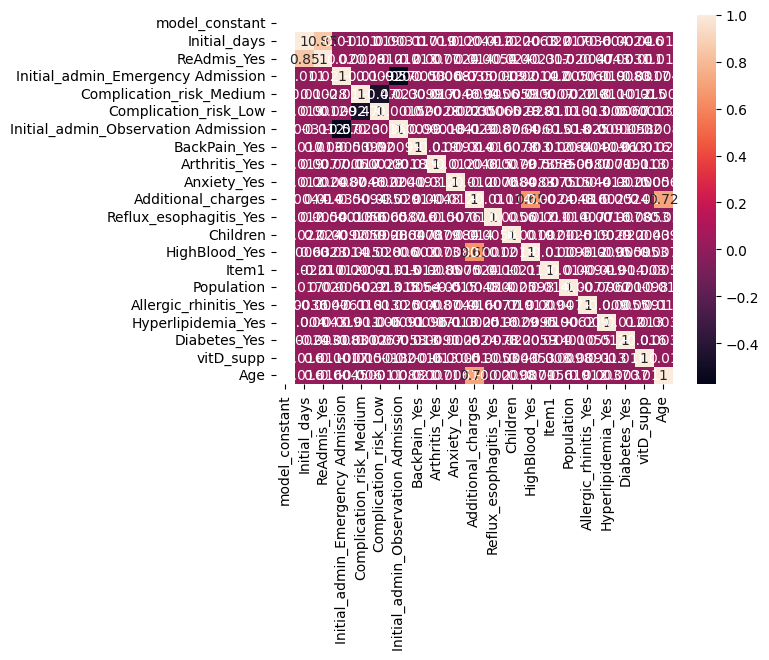

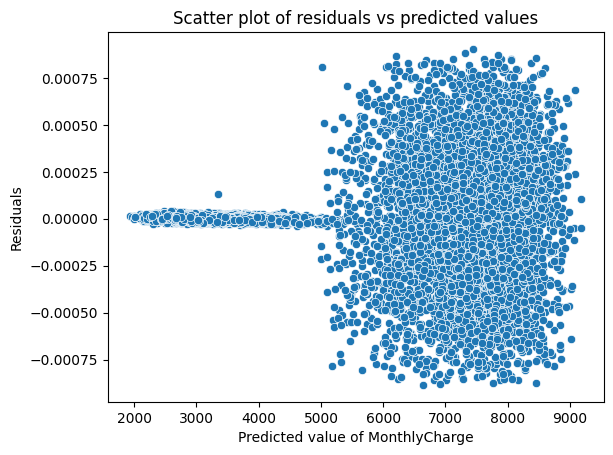

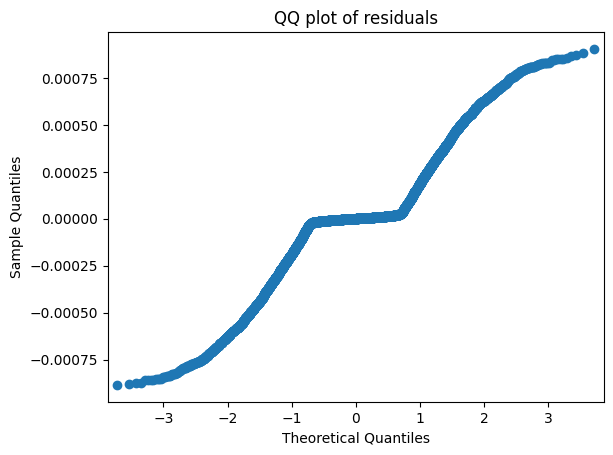

                                feature        VIF
0                        model_constant  35.543654
1                          Initial_days   3.647535
2                           ReAdmis_Yes   3.643630
3     Initial_admin_Emergency Admission   1.517806
4              Complication_risk_Medium   1.302038
5                 Complication_risk_Low   1.305242
6   Initial_admin_Observation Admission   1.497420
7                          BackPain_Yes   1.002553
8                         Arthritis_Yes   1.002735
9                           Anxiety_Yes   1.001440
10                   Additional_charges  16.131721
11               Reflux_esophagitis_Yes   1.001908
12                             Children   1.002302
13                        HighBlood_Yes   7.793505
14                                Item1   1.002628
15                           Population   1.002470
16                Allergic_rhinitis_Yes   1.002466
17                   Hyperlipidemia_Yes   1.001817
18                         Diab

In [10]:
lin_model(y_0, X_0)
rfe_review(y_0, X_0)

                            OLS Regression Results                            
Dep. Variable:            TotalCharge   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.300e+16
Date:                Sun, 21 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:21:24   Log-Likelihood:                 68292.
No. Observations:               10000   AIC:                        -1.366e+05
Df Residuals:                    9988   BIC:                        -1.365e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
model_

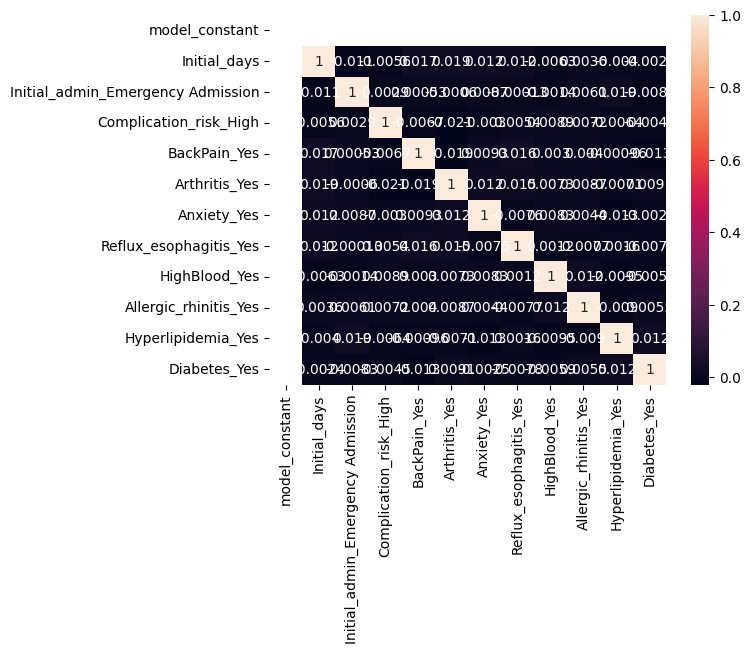

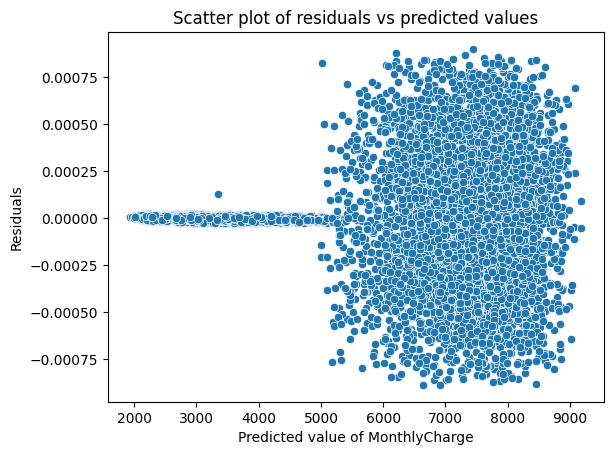

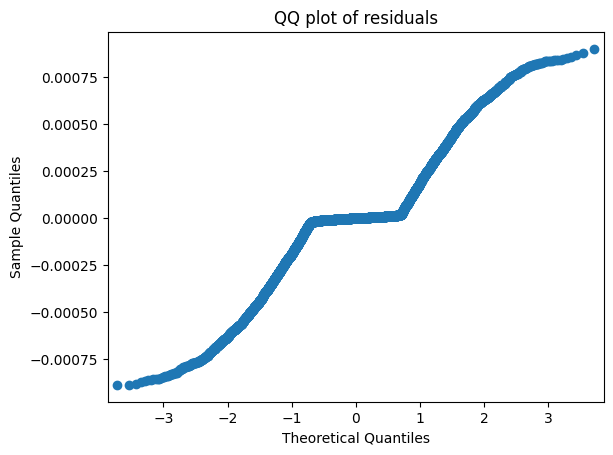

                              feature       VIF
0                      model_constant  8.789989
1                        Initial_days  1.001175
2   Initial_admin_Emergency Admission  1.000691
3              Complication_risk_High  1.000756
4                        BackPain_Yes  1.001267
5                       Arthritis_Yes  1.001800
6                         Anxiety_Yes  1.000779
7              Reflux_esophagitis_Yes  1.000850
8                       HighBlood_Yes  1.000512
9               Allergic_rhinitis_Yes  1.000524
10                 Hyperlipidemia_Yes  1.000953
11                       Diabetes_Yes  1.000623
                            OLS Regression Results                            
Dep. Variable:            TotalCharge   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.224e+06
Date:                Sun, 21 Apr 2024   Prob (F-statistic): 

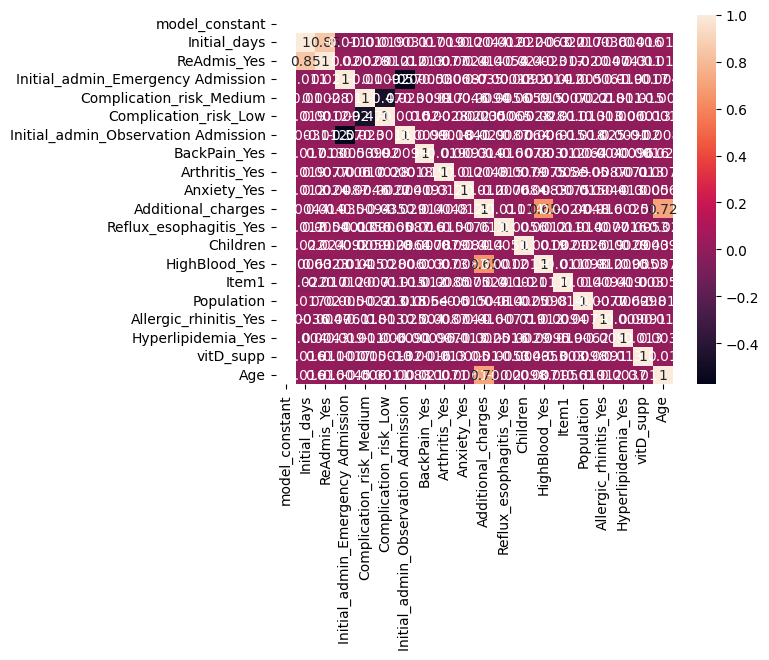

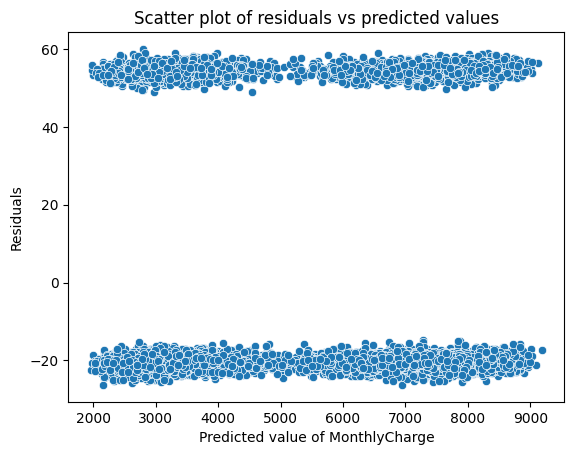

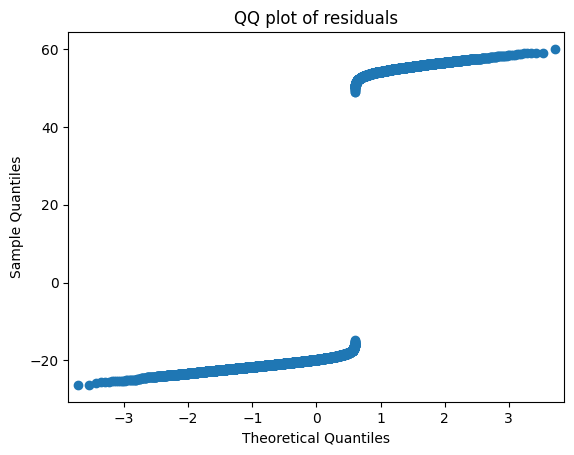

                                feature        VIF
0                        model_constant  35.187413
1                          Initial_days   3.647535
2                           ReAdmis_Yes   3.643619
3     Initial_admin_Emergency Admission   1.517587
4              Complication_risk_Medium   1.302022
5                 Complication_risk_Low   1.305144
6   Initial_admin_Observation Admission   1.497382
7                          BackPain_Yes   1.002392
8                         Arthritis_Yes   1.002654
9                           Anxiety_Yes   1.001433
10                   Additional_charges  16.127661
11               Reflux_esophagitis_Yes   1.001843
12                             Children   1.001805
13                        HighBlood_Yes   7.791327
14                                Item1   1.002451
15                           Population   1.002375
16                Allergic_rhinitis_Yes   1.002431
17                   Hyperlipidemia_Yes   1.001675
18                            v

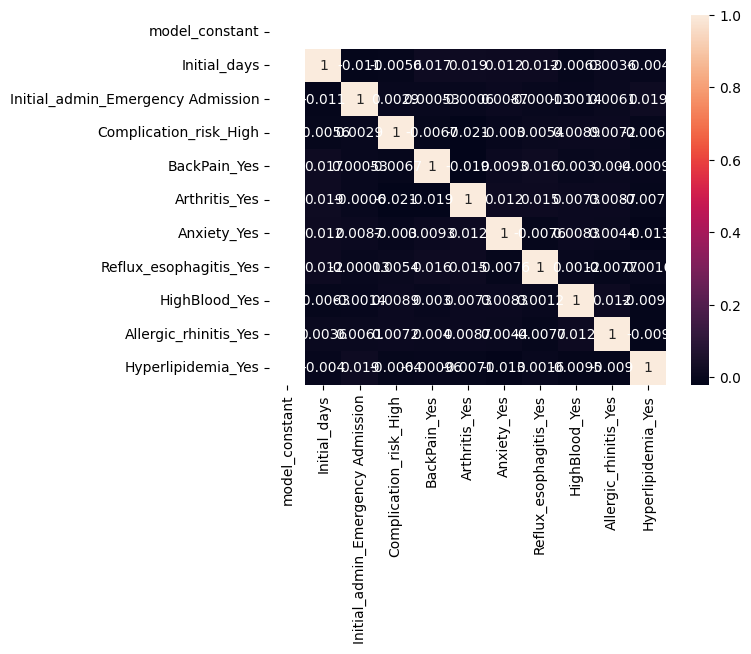

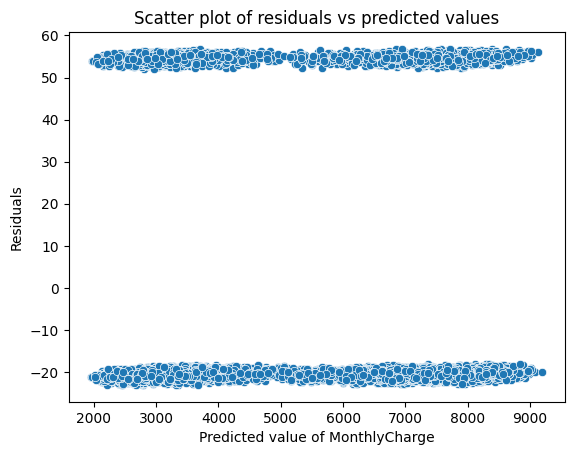

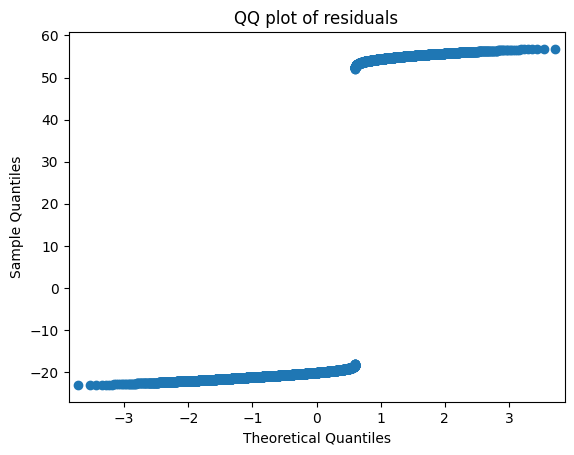

                              feature       VIF
0                      model_constant  8.389366
1                        Initial_days  1.001169
2   Initial_admin_Emergency Admission  1.000619
3              Complication_risk_High  1.000738
4                        BackPain_Yes  1.001096
5                       Arthritis_Yes  1.001718
6                         Anxiety_Yes  1.000774
7              Reflux_esophagitis_Yes  1.000791
8                       HighBlood_Yes  1.000479
9               Allergic_rhinitis_Yes  1.000492
10                 Hyperlipidemia_Yes  1.000811


In [11]:
# Refined model independent variables
model_indp_var_new = ['model_constant', 'Initial_days', 'Initial_admin_Emergency Admission',
                      'Complication_risk_High', 'BackPain_Yes', 'Arthritis_Yes',
                      'Anxiety_Yes', 'Reflux_esophagitis_Yes', 'HighBlood_Yes',
                      'Allergic_rhinitis_Yes', 'Hyperlipidemia_Yes', 'Diabetes_Yes']
model_dep_var_new = 'TotalCharge'
X_1 = df_med[model_indp_var_new]
y_1 = df_med[model_dep_var_new]


# Demonstrating difference without including 'Diabetes_Yes' on initial model
model_indp_var_comp = ['model_constant', 'Initial_days', 'ReAdmis_Yes', 'Initial_admin_Emergency Admission',
                  'Complication_risk_Medium', 'Complication_risk_Low', 'Initial_admin_Observation Admission',
                  'BackPain_Yes', 'Arthritis_Yes', 'Anxiety_Yes', 'Additional_charges', 'Reflux_esophagitis_Yes',
                  'Children', 'HighBlood_Yes', 'Item1', 'Population', 'Allergic_rhinitis_Yes', 'Hyperlipidemia_Yes',
                  'vitD_supp', 'Age']
model_dep_var_comp = 'TotalCharge'
X_2 = df_med[model_indp_var_comp]
y_2 = df_med[model_dep_var_comp]


# Demonstrating difference without including 'Diabetes_Yes' on refined model
model_indp_var_comp2 = ['model_constant', 'Initial_days', 'Initial_admin_Emergency Admission',
                      'Complication_risk_High', 'BackPain_Yes', 'Arthritis_Yes',
                      'Anxiety_Yes', 'Reflux_esophagitis_Yes', 'HighBlood_Yes',
                      'Allergic_rhinitis_Yes', 'Hyperlipidemia_Yes']
model_dep_var_comp2 = 'TotalCharge'
X_3 = df_med[model_indp_var_comp2]
y_3 = df_med[model_dep_var_comp2]


lin_model(y_1, X_1)
lin_model(y_2, X_2)
lin_model(y_3, X_3)